In [36]:
import numpy as np
from rdkit import Chem
from rdkit import DataStructs
import pickle
from rdkit.Chem.Draw import IPythonConsole
from rdkit import rdBase
print(rdBase.rdkitVersion)

import time
print(time.asctime())
%pylab inline

2017.03.3
Sat Aug 12 07:54:26 2017


In [2]:
%load_ext sql
%config SqlMagic.feedback = False

/home/glandrum/anaconda3/envs/py36/lib/python3.6/site-packages/IPython/config.py:13: ShimWarning: The `IPython.config` package has been deprecated since IPython 4.0. You should import from traitlets.config instead.
  "You should import from traitlets.config instead.", ShimWarning)
/home/glandrum/anaconda3/envs/py36/lib/python3.6/site-packages/sql/magic.py:4: UserWarning: IPython.utils.traitlets has moved to a top-level traitlets package.
  from IPython.utils.traitlets import Bool, Int, Unicode


In [3]:
import glob
pkls = glob.glob('/home/glandrum/Code/benchmarking_platform/compounds/ChEMBL_II/*.pkl')
print(len(pkls))

37


In [4]:
import os
tgts={}
for pkl in pkls:
    fn = os.path.split(pkl)[-1]
    basen = os.path.splitext(fn)[0]
    tgtn=int(basen.split('_')[-1])
    data = %sql postgresql://localhost/chembl_23 \
          select tid,pref_name,organism from target_dictionary where tid=:tgtn ;
    tgts[data[0][0]]=(pkl,data[0][1],data[0][2])

In [13]:
for idx in sorted(tgts):
    pkl,tgt,species = tgts[idx]
    print(idx,len(pickle.load(open(pkl,'rb'))),tgt,species)

15 33 Carbonic anhydrase II Homo sapiens
25 6 Glucocorticoid receptor Homo sapiens
43 14 Beta-2 adrenergic receptor Homo sapiens
51 24 Serotonin 1a (5-HT1a) receptor Homo sapiens
61 7 Muscarinic acetylcholine receptor M1 Homo sapiens
65 6 Cytochrome P450 19A1 Homo sapiens
72 21 Dopamine D2 receptor Homo sapiens
87 32 Cannabinoid CB1 receptor Homo sapiens
90 4 Dopamine D4 receptor Homo sapiens
93 8 Acetylcholinesterase Homo sapiens
100 22 Norepinephrine transporter Homo sapiens
107 20 Serotonin 2a (5-HT2a) receptor Homo sapiens
108 15 Serotonin 2c (5-HT2c) receptor Homo sapiens
114 33 Adenosine A1 receptor Homo sapiens
121 37 Serotonin transporter Homo sapiens
126 8 Cyclooxygenase-2 Homo sapiens
130 25 Dopamine D3 receptor Homo sapiens
165 32 HERG Homo sapiens
259 33 Cannabinoid CB2 receptor Homo sapiens
10188 18 MAP kinase p38 alpha Homo sapiens
10193 33 Carbonic anhydrase I Homo sapiens
10260 4 Vanilloid receptor Homo sapiens
10280 23 Histamine H3 receptor Homo sapiens
10434 8 Tyrosin

In [14]:
sets = pickle.load(open(tgts[72][0],'rb'))
cmpds = {}
for docid,data in sets.items():
    ids,smis= zip(*data)
    cmpds[int(docid)] = (ids,[Chem.MolFromSmiles(x) for x in smis])

In [15]:
for k in cmpds:
    print(k,len(cmpds[k][0]))

51800 29
58470 16
31339 21
45210 25
37020 39
57508 27
20155 19
36047 32
5330 10
36568 54
38128 15
30988 24
47889 17
36636 23
31527 31
51064 14
31631 51
30616 20
43952 16
30653 15
60894 20


In [24]:
import gzip
decoys = [Chem.MolFromSmiles(x.split()[-1]) for x in \
          gzip.open('/home/glandrum/Code/benchmarking_platform/compounds/ChEMBL/cmp_list_ChEMBL_zinc_decoys.dat.gz').readlines()]
decoys = [x for x in decoys if x is not None]
len(decoys)

RDKit ERROR: [07:37:57] SMILES Parse Error: syntax error for input: 'SMILES'


10000

In [89]:
from sklearn.utils import check_array
from sklearn.tree._tree import DTYPE, DOUBLE
from sklearn.ensemble import RandomForestClassifier

def get_predfp(self, X):
    X = check_array(X, dtype=DTYPE, accept_sparse='csr')

    n_classes_ = self.n_classes_
    n_estimators = len(self.estimators_)
    n_samples = X.shape[0]

    predictions = []

    for k in range(n_samples):
        predictions.append(np.zeros((n_estimators,),np.int8))

    for i,estimator in enumerate(self.estimators_):
        p_estimator = estimator.predict(X,
                                        check_input=False)
        for j,p in enumerate(p_estimator):
            predictions[j][i] = p
    return predictions
RandomForestClassifier.get_predfp = get_predfp
def get_probafp(self, X, tgt_class=1):
    """Compute out-of-bag score"""
    X = check_array(X, dtype=DTYPE, accept_sparse='csr')

    n_classes_ = self.n_classes_
    n_estimators = len(self.estimators_)
    n_samples = X.shape[0]

    predictions = []

    for k in range(n_samples):
        predictions.append(np.zeros((n_estimators,),np.float32))

    for i,estimator in enumerate(self.estimators_):
        p_estimator = estimator.predict_proba(X,
                                        check_input=False)
        for j,p in enumerate(p_estimator):
            predictions[j][i] = p[tgt_class]
    return predictions
RandomForestClassifier.get_probafp = get_probafp

# not currently doing anything with this, but it has the logic for how OOB is done
def _set_oob_score(self, X, y):
    """Compute out-of-bag score"""
    X = check_array(X, dtype=DTYPE, accept_sparse='csr')

    n_classes_ = self.n_classes_
    n_samples = y.shape[0]

    oob_decision_function = []
    oob_score = 0.0
    predictions = []

    for k in range(self.n_outputs_):
        predictions.append(np.zeros((n_samples, n_classes_[k])))

    for estimator in self.estimators_:
        unsampled_indices = _generate_unsampled_indices(
            estimator.random_state, n_samples)
        p_estimator = estimator.predict_proba(X[unsampled_indices, :],
                                              check_input=False)

        if self.n_outputs_ == 1:
            p_estimator = [p_estimator]

        for k in range(self.n_outputs_):
            predictions[k][unsampled_indices, :] += p_estimator[k]

    for k in range(self.n_outputs_):
        if (predictions[k].sum(axis=1) == 0).any():
            warn("Some inputs do not have OOB scores. "
                 "This probably means too few trees were used "
                 "to compute any reliable oob estimates.")

        decision = (predictions[k] /
                    predictions[k].sum(axis=1)[:, np.newaxis])
        oob_decision_function.append(decision)
        oob_score += np.mean(y[:, k] ==
                             np.argmax(predictions[k], axis=1), axis=0)

    if self.n_outputs_ == 1:
        self.oob_decision_function_ = oob_decision_function[0]
    else:
        self.oob_decision_function_ = oob_decision_function

    self.oob_score_ = oob_score / self.n_outputs_

In [39]:
from rdkit.Chem import rdMolDescriptors
def fpfunc(x):
    fp = rdMolDescriptors.GetMorganFingerprintAsBitVect(x,2,2048)
    res = np.zeros(len(fp),np.int8)
    DataStructs.ConvertToNumpyArray(fp,res)
    return res
fps = {}
for docid in cmpds:
    ids,ms = cmpds[docid]
    fps[docid] = (ids,[fpfunc(x) for x in ms])
decoy_fps = [fpfunc(x) for x in decoys]

In [158]:
import random
from collections import namedtuple
from sklearn.ensemble import RandomForestClassifier

model_res = namedtuple('ModelResult',('model','train_docs','test_docs','confusion','auc','enrichment'))
def build_model(cmpds,fps,decoy_fps,random_state=0xf00d):
    mdl = RandomForestClassifier(n_estimators = 500,max_depth=25,n_jobs=-1, 
                                 random_state = random_state, oob_score=True)
    to_use = list(cmpds.keys())
    random.seed(random_state)
    random.shuffle(to_use)
    train = to_use[:-5]
    test = to_use[-5:]
    train_fps = []
    for docid in train:
        train_fps.extend(fps[docid][-1])
    train_acts = [1 for x in train_fps]

    decoy_order = list(range(len(decoy_fps)))
    random.shuffle(decoy_order)
    nDecoy = int(0.8  * len(decoy_order))
    train_fps.extend(decoy_fps[x] for x in decoy_order[:nDecoy])
    train_acts.extend(0 for x in range(nDecoy))

    train_order = list(range(len(train_fps)))
    random.shuffle(train_order)
    train_fps = [train_fps[x] for x in train_order]
    train_acts = [train_acts[x] for x in train_order]

    mdl.fit(np.array(train_fps),train_acts)
    
    
    test_fps = []
    for docid in test:
        test_fps.extend(fps[docid][-1])
    test_acts = [1 for x in test_fps]
    test_fps.extend(decoy_fps[x] for x in decoy_order[nDecoy:])
    test_acts.extend(0 for x in decoy_order[nDecoy:])

    nGood=0
    nBad=0
    confusion = np.zeros((2,2),np.integer)
    preds = mdl.predict(test_fps)
    for pred,act in zip(preds,test_acts):
        confusion[act,pred] += 1
    print(confusion)
    probs = [x[1] for x in mdl.predict_proba(test_fps)]

    from rdkit.ML.Scoring import Scoring
    sm = [[x,y] for x,y in zip(probs,test_acts)]
    auc = Scoring.CalcAUC(sm,1)
    print('auc:', auc)
    enrich=Scoring.CalcEnrichment(sm,1,(0.01,0.050,0.1))
    print('enrich: ',enrich)
    #'model','train_docs','test_docs','confusion','auc','enrichment'
    res = model_res(mdl,train,test,confusion,auc,enrich)
    return res

In [159]:
seeds = (random.randint(0,1000000) for x in range(10))
results = [build_model(cmpds,fps,decoy_fps,x) for x in seeds]

[[2000    0]
 [  93   55]]
auc: 1.0
enrich:  [14.513513513513514, 14.513513513513514, 9.990697674418604]
[[2000    0]
 [ 111   29]]
auc: 1.0
enrich:  [15.285714285714286, 15.285714285714286, 10.0]
[[2000    0]
 [  69   52]]
auc: 1.0
enrich:  [17.52892561983471, 17.52892561983471, 9.95774647887324]
[[2000    0]
 [  74   43]]
auc: 1.0
enrich:  [18.094017094017094, 18.094017094017094, 9.985849056603772]
[[2000    0]
 [  72   57]]
auc: 1.0
enrich:  [16.503875968992247, 16.503875968992247, 9.995305164319248]
[[2000    0]
 [ 120   35]]
auc: 1.0
enrich:  [13.903225806451612, 13.903225806451612, 9.976851851851851]
[[2000    0]
 [ 108   47]]
auc: 1.0
enrich:  [13.903225806451612, 13.903225806451612, 9.976851851851851]
[[2000    0]
 [ 138   17]]
auc: 1.0
enrich:  [13.903225806451612, 13.903225806451612, 9.976851851851851]
[[2000    0]
 [ 104   17]]
auc: 1.0
enrich:  [17.52892561983471, 17.52892561983471, 9.95774647887324]
[[2000    0]
 [  76   40]]
auc: 1.0
enrich:  [18.24137931034483, 18.241379

In [124]:
from scipy import stats
def sim_score(v1,v2):
    " this is the similarity score used for HTS FPs in http://pubs.acs.org/doi/abs/10.1021/cb3001028 "
    v1t = [1 if x>-1e-4 else 0 for x in v1]
    v2t = [1 if x>-1e-4 else 0 for x in v2]
    nv1 = sum(v1t)
    common = [x for x,(y1,y2) in enumerate(zip(v1t,v2t)) if (y1 and y2)]
    coverage = len(common) / nv1
    v1common = [v1[x] for x in common]
    v2common = [v2[x] for x in common] 
    pearson = stats.pearsonr(v1common,v2common)[0]
    return (coverage/2+0.5)*pearson

In [132]:
r = results[0]
r

ModelResult(model=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=25, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=-1, oob_score=True,
            random_state=633822, verbose=0, warm_start=False), train_docs=[60894, 31527, 30616, 51800, 36047, 20155, 58470, 36636, 57508, 31339, 30653, 37020, 36568, 5330, 47889, 30988], test_docs=[31631, 45210, 38128, 43952, 51064], confusion=array([[2000,    0],
       [  95,   26]]), auc=1.0, enrichment=[17.52892561983471, 17.52892561983471, 9.95774647887324])

In [150]:
def getpredfps(mdl,fps,docs):
    tfps = {}
    for docid in docs:
        doc_fps = fps[docid][1]
        doc_fps = mdl.get_probafp(doc_fps)
        tfps[docid]=doc_fps
    sims = {}
    for docid in tfps:
        tsims = []
        docfps = tfps[docid]
        for i in range(len(docfps)):
            for j in range(i+1,len(docfps)):
                tsims.append(sim_score(docfps[i],docfps[j]))
        sims[docid] = tsims
    return sims
#for docid in r.test_docs:
#    tfps = 

/home/glandrum/anaconda3/envs/py36/lib/python3.6/site-packages/scipy/stats/stats.py:3021: RuntimeWarning: invalid value encountered in float_scalars
  r = r_num / r_den


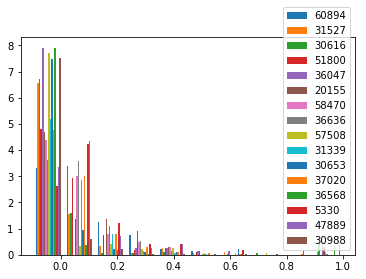

In [152]:
trainsims = getpredfps(r.model,fps,r.train_docs)
data = trainsims.values()
hist(data,normed=True,);
legend(trainsims.keys());

In [155]:
testsims = getpredfps(r.model,fps,r.test_docs)

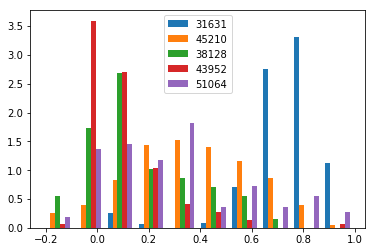

In [157]:
data = testsims.values()
hist(data,normed=True,);
legend(testsims.keys());